# Преобразование 2D-изображения

In [27]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

## Импорт изображения из файла

In [28]:
from PIL import Image
# Load a BMP image
image_path = 'images/couple.bmp'
img = Image.open(image_path)

# Display basic information about the image
print(f"Image Format: {img.format}")
print(f"Image Size: {img.size}")
print(f"Image Mode: {img.mode}")

Image Format: BMP
Image Size: (512, 512)
Image Mode: L


Массив беззнакового типа необходимо преобразовать в знаковый.

In [29]:
# uint8
f = np.array(img)
print(f.dtype, ': [min, max]: [', f.min(), ',', f.max(), ']')

# int32
f=f.astype(int)
#f -= 256//2
print(f.dtype, ': [min, max]: [', f.min(), ',', f.max(), ']')

[Nrow, Ncol] = np.shape(f)

uint8 : [min, max]: [ 0 , 254 ]
int32 : [min, max]: [ 0 , 254 ]


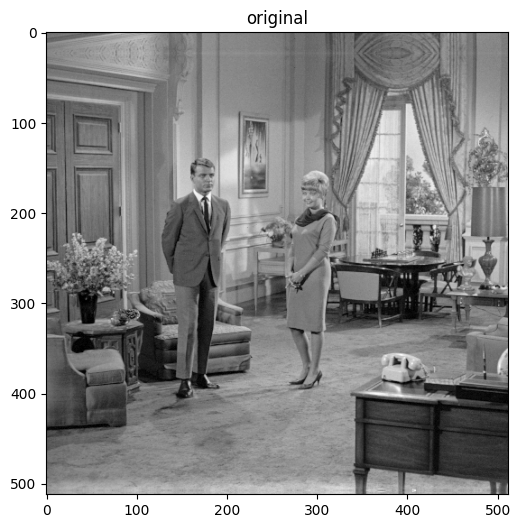

In [30]:
plt.figure(figsize=(8,6))
plt.imshow(f, cmap='gray')
plt.title('original')
plt.show()

## Кратномасштабный анализ вейвлетами 'daub 5/3 int-to-int'

Импорт пользовательских функций.

In [31]:
from Functions.daub_5_3_lift_2D import daub_5_3_lift_2D
from Functions.idaub_5_3_lift_2D import idaub_5_3_lift_2D

Функция 'daub_5_3_lift_2D' выполняет преобразование по схеме из книги [1], т.е. трендовые составляющие располагаются в левом нижнем углу.

In [32]:
# Number of levels.
K = 4
user_int_flag=True
user_fontsize = 14

coeff = np.empty(K, dtype='object')
for k in range(K):
    if k == 0:
        coeff[k] = f.copy()
    else:
        coeff[k] = coeff[k-1].copy()
    coeff[k][-Nrow//2**k:,:Ncol//2**k] = daub_5_3_lift_2D(coeff[k][-Nrow//2**k:,:Ncol//2**k], int_flag=user_int_flag)

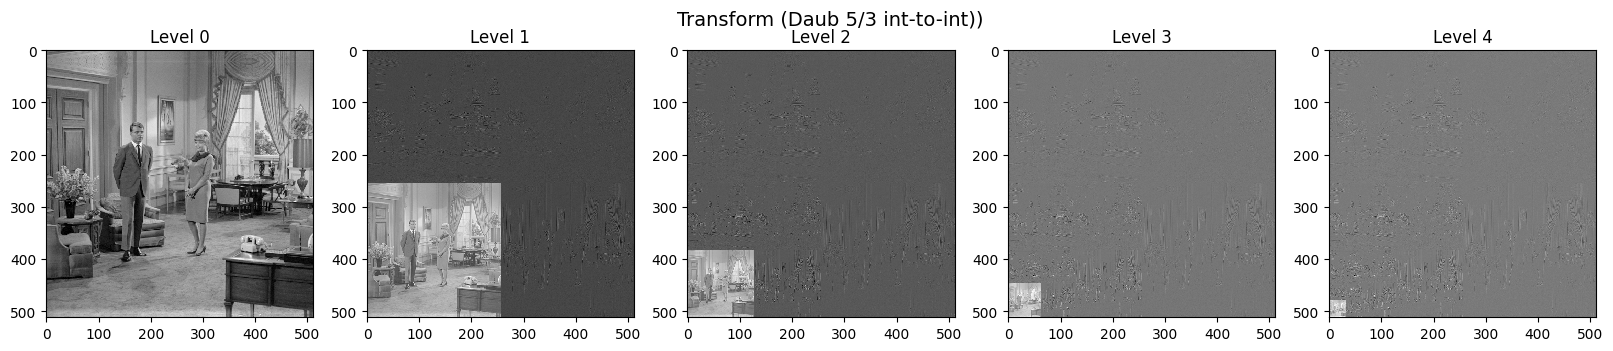

In [33]:
fig, axs = plt.subplots(ncols=K+1, nrows=1, figsize=(4*(K+1), 4))
for k, ax in enumerate(axs.flat):
    if k == 0:
        ax.imshow(f, cmap='gray', interpolation='none')
        ax.set_title('Level ' + str(k))
    else:
        ax.imshow(coeff[k-1], cmap='gray', interpolation='none')
        ax.set_title('Level ' + str(k))
plt.text(-250*(K+1), -50, 'Transform (Daub 5/3 int-to-int))', fontsize=user_fontsize)
plt.savefig('readme_img/transform_daub_5_3_int.png', bbox_inches='tight')
plt.show()

### Обратное преобразование

In [34]:
f_rec = np.empty(K, dtype='object')

for k in reversed(range(K)):
    f_rec[k] = coeff[k].copy()
    f_rec[k][-Nrow//2**k:,:Ncol//2**k] = idaub_5_3_lift_2D(coeff[k][-Nrow//2**k:,:Ncol//2**k], int_flag=user_int_flag)

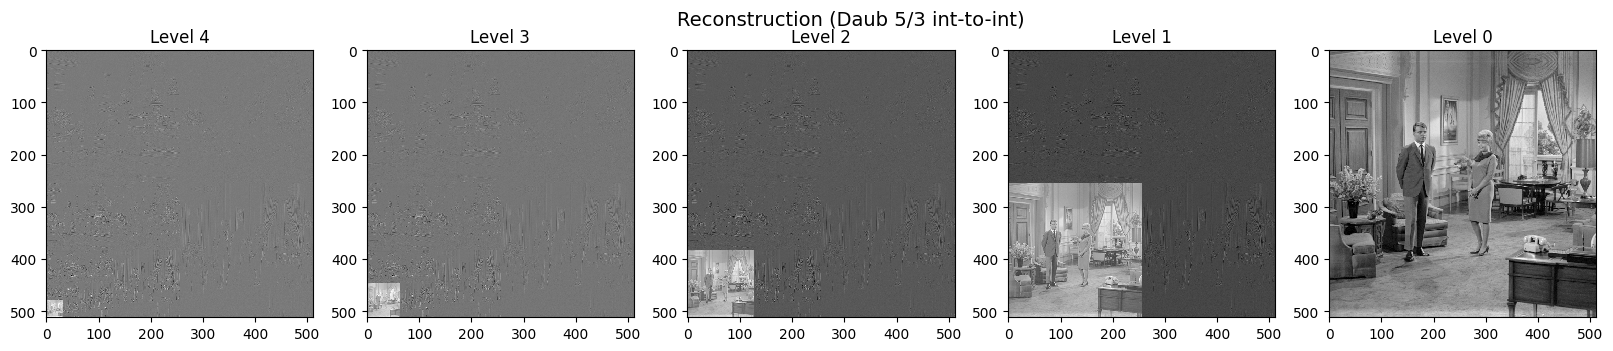

In [35]:
fig, axs = plt.subplots(ncols=K+1, nrows=1, figsize=(4*(K+1), 4))
for k, ax in enumerate(axs.flat):
    if k == 0:
        ax.imshow(coeff[K-1], cmap='gray', interpolation='none')
        ax.set_title('Level ' + str(K))
    else:
        ax.imshow(f_rec[K-k], cmap='gray', interpolation='none')
        ax.set_title('Level ' + str(K-k))
plt.text(-250*(K+1), -50, 'Reconstruction (Daub 5/3 int-to-int)', fontsize=user_fontsize)
plt.savefig('readme_img/reconstruction_daub_5_3_int.png', bbox_inches='tight')
plt.show()

Проверка:

In [36]:
for k in range(K):
    if k == 0:
        print('Difference (sum squared) at Level ' + str(k) + ':', np.sum((f-f_rec[k])**2))
    else:
        print('Difference (sum squared) at Level ' + str(k) + ':', np.sum((coeff[k-1]-f_rec[k])**2))

Difference (sum squared) at Level 0: 0
Difference (sum squared) at Level 1: 0
Difference (sum squared) at Level 2: 0
Difference (sum squared) at Level 3: 0


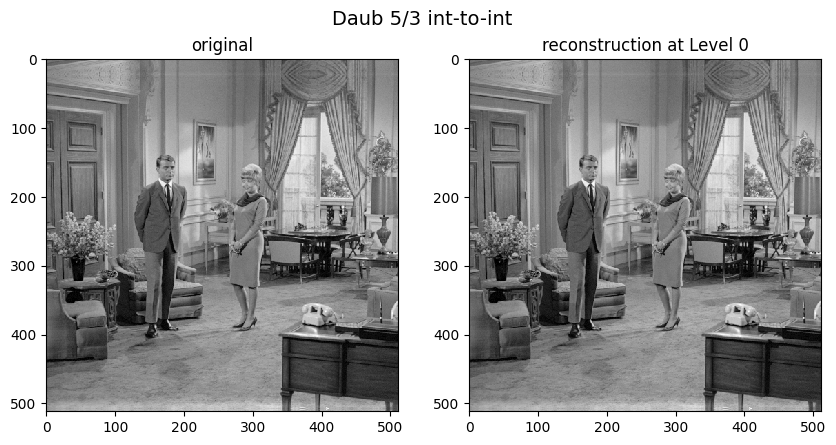

In [37]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
axs.flat[0].imshow(f, cmap='gray', interpolation='none')#, vmin=-2**bits//2, vmax=2**bits//2-1)
axs.flat[0].set_title('original')
axs.flat[1].imshow(f_rec[0], cmap='gray', interpolation='none')#, vmin=-2**bits//2, vmax=2**bits//2-1)
axs.flat[1].set_title('reconstruction at Level 0')
plt.text(-200, -50, 'Daub 5/3 int-to-int', fontsize=user_fontsize)
plt.savefig('readme_img/comparison_daub_5_3_int.png', bbox_inches='tight')
plt.show()

### Энергия

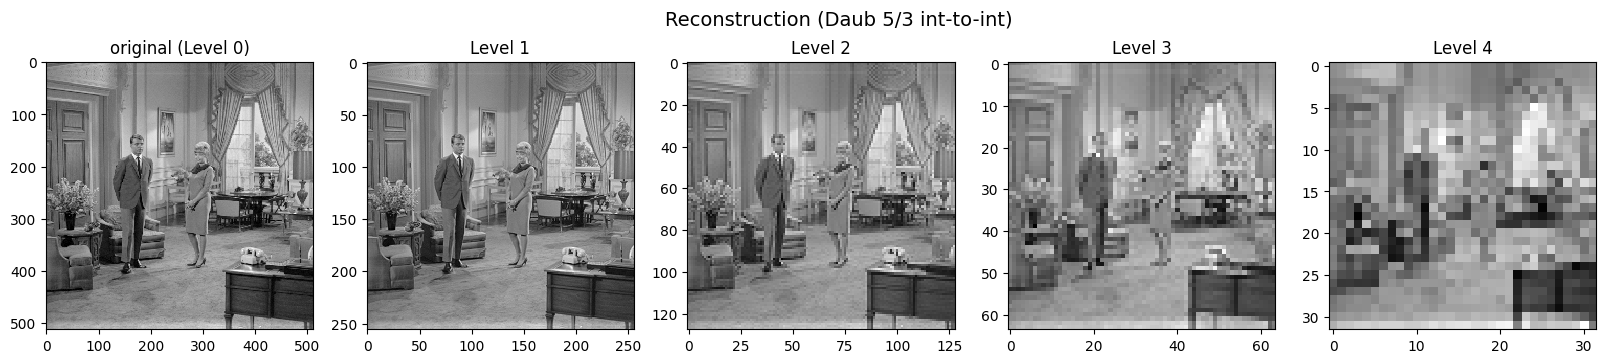

In [38]:
fig, axs = plt.subplots(ncols=K+1, nrows=1, figsize=(4*(K+1), 4))
for k, ax in enumerate(axs.flat):
    if k == 0:
        ax.imshow(f, cmap='gray', interpolation='none')
        ax.set_title('original (Level 0)')
    else:    
        ax.imshow(coeff[k-1][-Nrow//2**k:,:Ncol//2**k], cmap='gray', interpolation='none')
        ax.set_title('Level ' + str(k))
plt.text(-80, -5, 'Reconstruction (Daub 5/3 int-to-int)', fontsize=user_fontsize)
plt.savefig('readme_img/trends_daub_5_3_int.png', bbox_inches='tight')
plt.show()

Total Energy (Signal) 4347469750.0
Total Energy (Coeffs) 1103611873.0


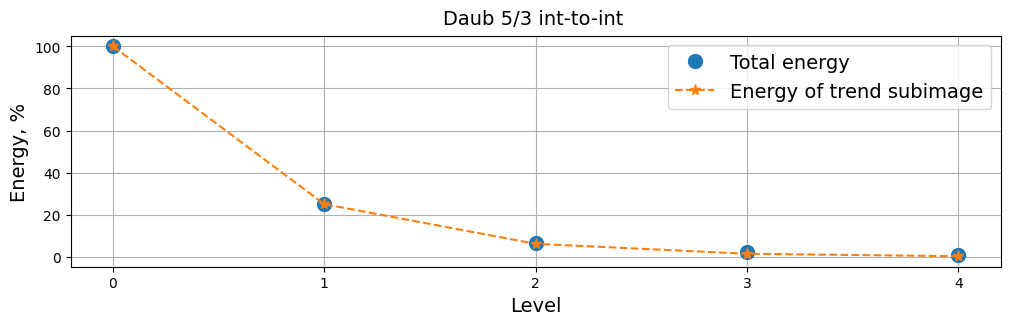

In [39]:
print('Total Energy (Signal)', np.round(np.sum(f.astype(float)**2),2))
print('Total Energy (Coeffs)', np.round(np.sum(coeff[0].astype(float)**2),2))

full_energy_rec = np.sum(f_rec[0].astype(float)**2)
full_energy = [100.0]
trend_energy = [100.0]
for k in range(K):
    full_energy.append(np.sum(coeff[k].astype(float)**2) / full_energy_rec * 100)
    trend_energy.append(np.sum((coeff[k][-Nrow//2**(k+1):,:Ncol//2**(k+1)]).astype(float)**2) / full_energy_rec * 100)
fig, ax = plt.subplots()
fig.set_figheight(3)
fig.set_figwidth(12)
ax.plot(full_energy, 'o', markersize=10, label='Total energy')
ax.plot(trend_energy, '*--', markersize=8, label='Energy of trend subimage')
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel('Level', fontsize=user_fontsize)
plt.ylabel('Energy, %', fontsize=user_fontsize)
plt.grid(True)
plt.legend(fontsize=user_fontsize)
plt.text(0.4, 1.05, 'Daub 5/3 int-to-int', transform=ax.transAxes, fontsize=user_fontsize)
plt.savefig('readme_img/energy_daub_5_3_int.png', bbox_inches='tight')
plt.show()